# Support Vector Machines for Binary Classifcation

(NEEDS TO BE REWRITTEN FOR CONSISTENCY WITH FINAL VERSION OF THE NOTEBOOK).

Creating binary classifiers from sample data is an example of supervised machine learning. This notebook shows how to create a class of binary classifiers  known as support vector machines (SVM) from sample data using linear, quadratic, and conic programming. The first implementation produces linear support vector machines that separates the "feature space" with a hyperplane. The  implementation uses a dual formulation that extends naturally to non-linear classification.

Like many machine learning techniques based on regression, an SVM classifier can be computed from the solution to an optimization problem. The use of modeling languages and general purpose solvers can support small

The dual optimization problem is the basis for a second implementation. A technical feature of the dual problem extends support vector machines to nonlinear classifiers that have proven highly successful in a wide range of applications.  

## Bibliographic Notes

The development of support vector machines is largely attributed to Vladimir Vapnik and colleagues at AT&T Bell Laboratories during the 1990's. The seminal papers are highly readable and entry points to the literature.

> Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992, July). A training algorithm for optimal margin classifiers. In Proceedings of the fifth annual workshop on Computational learning theory (pp. 144-152).  https://dl.acm.org/doi/10.1145/130385.130401

> Cortes, C., & Vapnik, V. (1995). Support-vector networks. Machine learning, 20(3), 273-297. https://link.springer.com/content/pdf/10.1007/bf00994018.pdf

Support vector machines are a widely used method for supervised machine learning and described in tutorial blog postings and trade journal articles. Representative examples include 

> Sachin, D. N. (2020). Support Vector Machines with Amazon Food Reviews https://medium.com/analytics-vidhya/support-vector-machines-with-amazon-food-reviews-9fe0428e09ef

> http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-linear-svm/



## Binary Classification

Binary classifiers are functions that answer questions like "does this medical test indicate disease?", "will that customer like this movie?", "does this photo contain the image of a car?", or "is this banknote authentic or counterfeit?" The answer is based on values of "features" that may include physical measurements, values representing color of image pixels, data collected from a web page.  Depending on the application requirements, classifiers can be tuned for precision (meaning few false positives), recall (meaning few false negatives), or some trade-off between these qualities.

* **Precision**. The number of real positives divided by the number of predicted positives. High precision implies a low false positive rate.

* **Recall**. The number of real positives divided by number of actual positives. High recall test implies a low false negative rate.

Consider, for example, an device that rejects counterfeit banknotes for a vending machine. A false positive would mean the vending machine would rejects a genuine banknote which would be frustrating to a user. Users of the vending machine, therefore, would prefer a device with high precision. 

On the other hand, a false negative would mean the vending machine would accept a counterfeit banknote. The owner of the vending machine, therefore, would prefer a device with high recall.

false positive  a counterfeit banknote, clearly an undesirable outcome for the seller. The seller would be interested in high precision. A buyer, however, may be frustrated if a valid banknote is needlessly rejected by the vending machine. The buyer would be interested in high recall.

The challenge of developing binary classifiers is to find features, and functions to evaluate those features, that provide the precision and recall needed for a particular application.

## The Data Set 

The following data set contains data from a collection genuine and counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images and a binary variable where 0 indicates genuine and 1 indicates counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

### Read data

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# read data set
df = pd.read_csv("data_banknote_authentication.txt", header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Select features and training sets

<AxesSubplot:xlabel='variance', ylabel='skewness'>

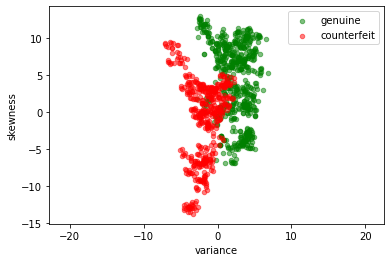

In [60]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)
df_train = df_train.reset_index()
df_test = df_test.reset_index()

features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 2 * df_train["class"] - 1

# separate into features and outputs
X_test = df_test[features]
y_test = 2 * df_test["class"] - 1


def plot_Xy(X, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    X[y < 0].plot(x=0, y=1, kind="scatter", ax=ax, c="g", alpha=0.5, label="genuine")
    X[y > 0].plot(
        x=0, y=1, kind="scatter", ax=ax, c="r", alpha=0.5, label="counterfeit"
    )
    ax.axis("equal")
    return ax


plot_Xy(X_train, y_train)

## Linear Support Vector Machines (SVM)

A linear support vector machine is a binary classifier that uses a linear expression to determine the classification. 

$$y = \text{sgn}\ ( w^\top x + b)$$

where $w\in \mathbb{R}^p$ is a set of coefficients and $w^\top x$ is the dot product. In effect, the linear function divides the feature space $\mathbb{R}^p$ with a hyperplane specified by $w$ and $b$.

A training or validation set consists of $n$ observations $(x_i, y_i)$ where $y_i = \pm 1$ and $x_i\in\mathbb{R}^p$ for $i=1, \dots, n$. The training task is to find coefficients $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$ to achieve high precision and high recall for a validation set. All points  $(x_i, y_i)$ for $i\in 1, \dots, n$ in a training or validation set are successfully classified if the
 
$$
\begin{align*}
y_i (w^\top x_i + b) & > 0 & \forall i = 1, 2, \dots, n
\end{align*}
$$

The strict inequality can be replaced by

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 & \forall i = 1, 2, \dots, n
\end{align*}
$$

which defines a **hard-margin** classifier where the size of the margin is determined by the scale of $w$ and $b$. The sample data displayed above shows it is not always possible to perfectly separate a data set into two classes. For that reason a **soft-margin** classifier is defined by slack variables $z_i \geq 0$ 

$$y_i (w^\top x_i + b) \geq 1 - z_i $$

For parameters $w$ and $b$, every point that satisfies the constraint with $z_i = 0$ is correctly classified with a hard margin ??? from the separating hyperplane. Points where $0 < z_i < 1$ will also be correctly classified. Point with slack variable $z_i > 1$ will be misclassified.

Given parameters $w$ and $b$, the **hinge-loss** function is defined as

$$\ell(x, y) = \left(1 - y(w^\top x + b)\right)_+$$

using the notation $\left(z\right)_+ = \max(0, z)$. 

The hinge-loss function has properties that make it useful fitting linear support vector machine.  For a properly classified point the hinge-loss will be less than one but never smaller than zero. For a mis-classified point, however, the hinge-loss function is greater than one and will grows in proportion to how far away the feature vector is from the separation plane. Minimizing the sum of hinge-loss functions locates hyperplane a that trades off between a margin for correctly classified points and minimizing the distance between the hyperplane and mis-classified points.


One approach to fitting a linear SVM is to assign a regularization term for $w$. In most formulations a norm $\|w\|$ is used for regularization, commonly a sum of squares such as $\|w\|_2^2$. Another choice is $\|w\|_1$ which, similar to Lasso regression, may result in sparse weighting vectors $w$ indicating which elements of the feature vector can be neglected for classification purpose. These considerations result i the objective function

$$\min_{w, b}\left[ \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)_+ + \lambda \|w\|_1\right]$$

which can be solved by linear programming.

$$
\begin{align*}
\min_{z, w, b}\ & \frac{1}{n}  \sum_{i=1}^n z_i + \lambda \|w\|_1 \\
\text{s.t.}\qquad z_i & \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, 2, \dots, n \\
z_i & \geq 0 & \forall i = 1, 2, \dots, n
\end{align*}
$$

This is the primal optimization problem in decision variables $w\in\mathbb{R}^p$, $b\in\mathbb{R}$, and $z\in\mathbb{R}^n$, a total of $n + p + 1$ unknowns with $2n$ constraints.

## Alternative Formulation of Linear SVM

The standard formulation of a linear support vector machine uses training sets $p$-element feature vectors $x_i\in\mathbb{R}^p$, a classification for those vectors, $y_i = \pm 1$ and a classifier defined by $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$

$$
\begin{align*}
y & = \text{sgn}(w^\top x + b)
\end{align*}
$$

The parameter $b$ is an annoying term that unnecessarily clutters the presentation and derivations. As an alternative formulation, consider an augmented feature vector $\bar{x} = (1, x) \in \mathbb{R}^{p+1}$ and parameter vector $\bar{w} = (b, w) \in \mathbb{R}^{p+1}$. The linear SVM machine then becomes

$$
\begin{align*}
y & = \text{sgn}(\bar{w}^\top \bar{x})
\end{align*}
$$

If a hard-margin classifier exists for a training or validation set $(\bar{x}_i, y_i)$ for $i=1, \dots, n$ then it would satisfy

$$
\begin{align*}
y_i \bar{w}^\top \bar{x}_i & \geq 1 & \forall i \in 1, 2, \dots, n
\end{align*}
$$

The separating hyperplane consists of all points normal to $\bar{w}$. The distance between $x_i$ and the separating  hyperplane is 

$$\frac{\bar{w}^\top \bar{x}_i}{\|\bar{w}\|}$$

The soft-margin classifier is found by solving

$$
\begin{align*}
\min \frac{1}{2} \|\bar{w}\|_2^2 & + \frac{c}{n}\sum_{i=1}^n z_i \\
\text{s.t.} \qquad z_i & \geq 1 - y_i \bar{w}^\top \bar{x}_i & \forall i = 1, 2, \dots, n \\
z_i & \geq 0 & \forall i = 1, 2, \dots, n
\end{align*}
$$

Recasting as a conic program

$$
\begin{align*}
& \min_{r, \alpha}\ r + \frac{c}{n} 1^\top z\\
\text{s. t.}\qquad & (r, 1, \bar{w}) \in Q_r^{3 + p} \\
& z + F \bar{w} \geq 1  \\
& z \geq 0 \\
\end{align*}
$$


In [191]:
import pyomo.kernel as pmo

def svm_conic_primal(X, y, c):
    
    n, p = X.shape
    F = np.array([y[i]*np.append(1, X.loc[i, :].to_numpy()) for i in range(n)])
    
    m = pmo.block()
    
    m.r = pmo.variable()
    
    m.w = pmo.variable_list()
    for i in range(p + 1):
        m.w.append(pmo.variable())
        
    m.z = pmo.variable_list()
    for i in range(n):
        m.z.append(pmo.variable(lb=0))
        
    m.primal = pmo.objective(expr=m.r + (c/n)*sum(m.z[i] for i in range(n)))

    m.qr = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.w)
    
    m.d = pmo.constraint_dict()
    for i in range(n):
        m.d[i] = pmo.constraint(body=m.z[i] + sum(F[i, j]*m.w[j] for j in range(p+1)), lb=1)
    
    pmo.SolverFactory('mosek_direct').solve(m)

    return m

c = 1.0

%timeit svm_conic_primal(X_train, y_train, c)
m = svm_conic_primal(X_train, y_train, c)

n, p = X_train.shape

print(m.r.value)

for j in range(p+1):
    print(j, m.w[j].value)
    
print()
for i in range(n):
    if m.z[i].value > 1:
        print(i, m.z[i].value)

406 ms ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.07200641543306915
0 0.0331810447205884
1 -0.3611410899436258
2 -0.11175402874221647

5 1.359091455501977
7 1.2541948152030387
20 1.602091538685219
21 1.2276046199107682
22 1.1574310326317327
24 1.0917509587731185
32 2.2290501119093706
42 1.0386475913247217
43 1.0384308976799776
45 1.8244816976858167
58 1.7883898309503
62 1.0427543058758248
67 1.8430866878614267
69 1.1047100674832462
71 1.8130596121470242
74 1.5690185059698254
102 1.0531610371681452
111 1.8235759493630794
113 1.0107042435600313
121 1.432285413069027
124 2.267786205170612
125 1.2342113978132807
138 1.2102554184223056
144 1.3036197862429748
150 1.1217697273532978
157 1.4571654611085683
160 1.7639750959190568
181 1.2102554184223056
183 1.05557846768545
185 2.0346337087618496
209 1.661344880925296
218 1.3487766024310917
222 1.4121665003659019
226 1.3315309829174216
230 1.8023391890442768
241 1.1582638425783283
253 1.9519048309189584
258 1.0355855958987124

Creating a differentiable Lagrangian with dual factors $\alpha_i$ for $i = 1, \dots, n$, the task is to find saddle points of

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|\bar{w}\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i (1 - y_i \bar{w}^\top \bar{x}_i - z_i) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

Taking derivatives with respect to the primal variables

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial \bar{w}} & = \bar{w}  - \sum_{i=1}^n \alpha_i y_i \bar{x}_i = 0 \implies  \bar{w} = \sum_{i=1}^n \alpha_i y_i \bar{x}_i \\
\end{align*}
$$

resulting in the dual formulation

$$
\begin{align*}
\max_{\alpha_i}\ &  \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

Rearranging as a standard quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

The $n \times n$ **Gram matrix** is defined as

$$G = \begin{bmatrix} 
\bar{x}_1^\top \bar{x}_1 & \dots & \bar{x}_1^\top \bar{x}_n \\ 
\vdots & \ddots & \vdots \\ 
\bar{x}_n^\top \bar{x}_1 & \dots & \bar{x}_n^\top \bar{x}_n 
\end{bmatrix}$$

where each entry is dot product of two vectors $\bar{x}_i, \bar{x}_j \in \mathbb{R}^{p+1}$.

Compared to the primal, the dual formulation has reduced to the number of decision variables from $n + p + 1$ to $n$. But this has come with the significant penalty of introducing a dense matrix with $n^2$ coefficients and potential processing time of order $n^3$. For large training sets, $n\sim 10^4-10^5$ this is prohibitively expensive.

### Reformulation as a conic program

Introduce the $n \times (p+1)$ matrix $F$ defined as

$$F = \begin{bmatrix} y_1 \bar{x}_1^\top \\ y_2 \bar{x}_2^\top \\ \vdots \\ y_n \bar{x}_n^\top \end{bmatrix}$$

Then introducing an additional decision variabl $r \geq 0$

$$
\begin{align*}
& \min_{r, \alpha}\ r - 1^\top \alpha\\
\text{s. t.}\qquad & \alpha^\top F F^\top \alpha \leq 2 r \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

Using the notation $\mathcal{Q}^m_r$ for a rotated quadratic cone (for example, see https://docs.mosek.com/modeling-cookbook/cqo.html#equation-eq-sec-qo-modeling-qset2)

$$\mathcal{Q}^m_r = \{z\in\mathbb{R}^m | 2z_1z_2 \geq z_3^2 + \cdots + z_m^2,\ z_1, z_2 \geq 0 \}$$

The quadratic constraint is reformulated as a rotated quadratic cone

$$\frac{1}{2}\alpha^\top F F^\top \alpha \leq r \iff (r, 1, F^\top \alpha) \in Q_r^{3 + p}$$

The reformulated dual problem is then

$$
\begin{align*}
& \min_{r, \alpha}\ r - 1^\top \alpha\\
\text{s. t.}\qquad & (r, 1, F^\top \alpha) \in Q_r^{3 + p} \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

The conic reformulation eliminates the need to store an $n\times n$ Gram matrix.

$$
\begin{align*}
& \min_{r, \alpha}\ r - 1^\top \alpha\\
\text{s. t.}\qquad & (r, 1, z) \in Q_r^{3 + p} \\
& z = F^\top \alpha \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$


In [148]:
import pyomo.kernel as pmo

def svm_conic_dual(X, y, c):
    
    n, p = X.shape
    F = np.array([y[i]*np.append(1, X.loc[i, :].to_numpy()) for i in range(n)])
    
    m = pmo.block()
    
    m.r = pmo.variable()
    m.a = pmo.variable_list()
    for i in range(n):
        m.a.append(pmo.variable(lb=0, ub=c/n))
        
    m.z = pmo.variable_list()
    for j in range(p + 1):
        m.z.append(pmo.variable())
        
    m.d = pmo.constraint_dict()
    for j in range(p + 1):
        #m.d[j] = pmo.linear_constraint(variables=[m.a, m.z[j]], coefficients=np.append(F[:,j], -1), rhs=0.0)
        m.d[j] = pmo.constraint(body=sum(F[i, j]*m.a[i] for i in range(n)) - m.z[j], rhs=0)
        
    m.o = pmo.objective(expr=m.r - sum(m.a[i] for i in range(n)))
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)
    
    pmo.SolverFactory('mosek_direct').solve(m)

    return m

c = 1.0
%timeit svm_conic(X_train, y_train, c)
m = svm_conic(X_train, y_train, c)
print(m.r.value)
n = len(m.a)
for i in range(n):
    if m.a[i].value > 1e-7 and m.a[i].value < c/n - 1e-7:
        print(i, m.a[i].value)

393 ms ± 44.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.07201324288912872
40 1.4538831619299917e-07
210 2.6858783400757923e-07
292 0.0003694994962618517
511 1.4644490839692908e-07
598 0.0009113022844328891
607 5.135401782476993e-07
608 4.073621290280359e-06
620 4.414124384720946e-06
751 0.0009114686099036929
896 0.0009114562027052138
1003 1.0018716489473188e-06


## Pyomo Implementation

In [147]:
import numpy as np
import pyomo.environ as pyo


def svm_fit(X, y, lambd=0):

    m = pyo.ConcreteModel()

    # zero-based indexing
    n, p = X.shape
    m.n = pyo.RangeSet(0, n - 1)
    m.p = pyo.RangeSet(0, p - 1)

    m.w = pyo.Var(m.p)
    m.b = pyo.Var()
    m.z = pyo.Var(m.n, domain=pyo.NonNegativeReals)
    m.wpos = pyo.Var(m.p, domain=pyo.NonNegativeReals)
    m.wneg = pyo.Var(m.p, domain=pyo.NonNegativeReals)

    @m.Constraint(m.n)
    def hinge_loss(m, n):
        return m.z[n] >= 1 - y[n] * (sum(m.w[p] * X.iloc[n, p] for p in m.p) + m.b)

    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(m.z[n] for n in m.n) / n + lambd * sum(
            m.wpos[p] + m.wneg[p] for p in m.p
        )

    pyo.SolverFactory("glpk").solve(m)

    w = np.array([m.w[p]() for p in m.p])
    b = m.b()

    # return a binary classifier
    def svm(x):
        return np.sign(w @ x + b)

    svm.w = w
    svm.b = b

    return svm


# create a linear SVM binary classifier

%timeit svm = svm_fit(X_train, y_train)

389 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


                   Test Data (n = 275)
                  y = 1       y = -1
 Predict y =  1     102        19    precision = 0.843
 Predict y = -1      14       140 
      Recall =     0.879


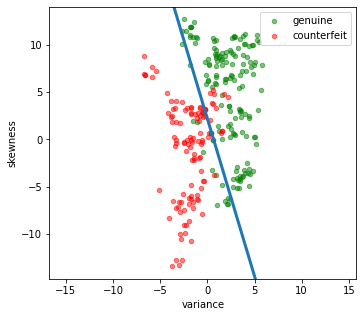

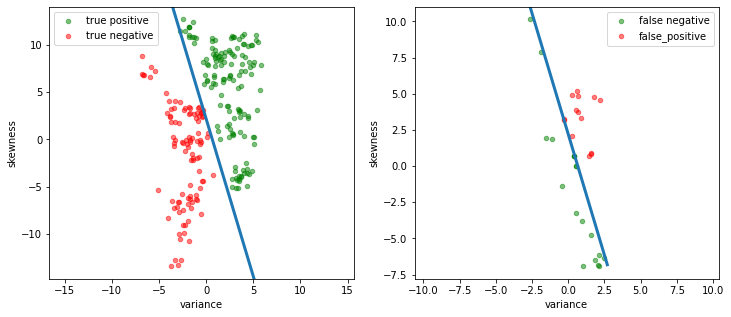

In [16]:
def svm_test(svm, X, y, plot=False):

    y_pred = pd.Series([svm(X.loc[i, :]) for i in X.index])

    true_pos = (y > 0) & (y_pred > 0)
    false_pos = (y < 0) & (y_pred > 0)
    false_neg = (y > 0) & (y_pred < 0)
    true_neg = (y < 0) & (y_pred < 0)

    tp = sum(true_pos)
    fp = sum(false_pos)
    fn = sum(false_neg)
    tn = sum(true_neg)

    print(f"                   Test Data (n = {len(y)})")
    print(f"                  y = 1       y = -1")
    print(f" Predict y =  1    {tp:4d}      {fp:4d}    precision = {tp/(tp + fp):5.3f}")
    print(f" Predict y = -1    {fn:4d}      {tn:4d} ")
    print(f"      Recall =     {tp/(tp + fn):5.3f}")

    if not plot:
        return

    def svm_line(svm, ax):
        w = svm.w
        b = svm.b
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.plot(
            [xmin, xmax], [-(w[0] * xmin + b) / w[1], -(w[0] * xmax + b) / w[1]], lw=3
        )
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5))
    plot_Xy(X, y, ax)
    svm_line(svm, ax)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_Xy(X[true_pos], y[true_pos], ax[0])
    plot_Xy(X[true_neg], y[true_neg], ax[0])
    svm_line(svm, ax[0])
    ax[0].legend(["true positive", "true negative"])

    plot_Xy(X[false_pos], y[false_pos], ax[1])
    plot_Xy(X[false_neg], y[false_neg], ax[1])
    svm_line(svm, ax[1])
    ax[1].legend(["false negative", "false_positive"])


svm = svm_fit(X_train, y_train)
svm_test(svm, X_test, y_test, plot=True)

In [17]:
features = df.columns

# separate into features and outputs
X_train_full = df_train[features]
y_train_full = 2 * df_train["class"] - 1

# separate into features and outputs
X_test_full = df_test[features]
y_test_full = 2 * df_test["class"] - 1

# fit svm and test
svm = svm_fit(X_train_full, y_train_full)
svm_test(svm, X_test_full, y_test_full)

                   Test Data (n = 275)
                  y = 1       y = -1
 Predict y =  1     116         0    precision = 1.000
 Predict y = -1       0       159 
      Recall =     1.000


## The SVM Dual

Creating the dual of the support vector machine will turn out to have practical consequences. Creating the dual requires a differentiable objective function. For this reason, the regularization term is changed to the 2-norm of $w$

$$
\begin{align*}
\min_{z, w, b}\  \frac{1}{2} \|w\|_2^2 + \frac{c}{n}  \sum_{i=1}^n z_i \\
\\
\text{s.t.}\qquad 1 - y_i(w^\top x_i + b) - z_i & \leq 0 & \forall i = 1, \dots, n \\
- z_i & \leq 0 & \forall i = 1, \dots, n
\end{align*}
$$

where the regularization parameter shifted to $c$, and the constraints restated in standard form. This is a quadratic problem in $n + p + 1$ variables and $2n$ constraints.

The Lagrangian $\mathcal{L}$ is 

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i (1 - y_i(w^\top x_i + b) - z_i) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

where $2n$ non-negative Lagrange multipliers $\alpha_i \geq 0$ and $\beta_1 \geq 0$ have been introduced for $i \in 1,\dots,n$. Intuitively, the Lagrange variables are penalty weights assigned to the inequality constraints introduced into a modified objective function. If the penalties are large enough then the constraints will be satisfied.


$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial w} & = w  - \sum_{i=1}^n \alpha_i y_i x_i = 0 \implies  w = \sum_{i=1}^n \alpha_i y_i x_i \\
\frac{\partial \mathcal{L}}{\partial b} & = -\sum_{i=1}^n \alpha_i y_i = 0 \implies \sum_{i=1}^n \alpha_i y_i = 0 \\
\end{align*}
$$

The dual problem is then

$$
\begin{align*}
\max_{\alpha_i}\ &  \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( x_i^\top x_j ) \\
\text{s. t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

Like the primal, the dual is a quadratic program. The dual, however, has only $n$ decision variables compared to $n + p + 1$ decision variables for the primal, and $n + 1$ constraints compared to $2n$ constraints for the primal. This reduction is significant for problems with many features (i.e, large $p$), or for large training sets (i.e., large $n$). The case of large $p$ becomes important when extending SVM to nonlinear classification using kernels. 

Note, however, that the reduced number of decision variables and constraints in the dual problem requires computing $\frac{n(n+1)}{2}$ inner products $(x_i^\top x_j)$ for $i \leq j$ and $i,j\in \mathbb{R}^n$.   The inner products can be arranged as a symmetric matrix 
$$
\begin{align*}
K = [k_{i,j}] = X X^\top = \begin{bmatrix}
x_1^\top x_1 & x_1^\top x_2 & \dots & x_1^\top x_n \\
x_2^\top x_1 & x_2^\top x_2 & \dots & x_2^\top x_n \\
\vdots & \vdots & \ddots & \vdots \\
x_n^\top x_1 & x_n^\top x_2 & \dots &  x_n^\top x_n \\
\end{bmatrix}
\end{align*}
$$

where $X \in \mathbb{R}^{n\times p}$ is the matrix formed by the $n$ feature vectors $x_i$ for $i=1, 2, \dots, n$. The symmetry of $K$, which is known as the Gram matrix (or Grammian) is a consequence of the symmetry of the inner product for real number spaces.

$$
\begin{align*}
w^* & = \sum_{i=1}^n \alpha_i^* y_i x_i \\
b^* & = y_k - (w^*)^\top x_k & \text{for any }k\ni 0 < \alpha_k < \frac{c}{n} \\
\end{align*}
$$

which can be written entirely in terms of the inner product.

$$
\begin{align*}
w^* & = \sum_{i=1}^n \alpha_i^* y_i x_i \\
b^* & = y_k - \sum_{i=1}^n \alpha_i^* y_i x_i^\top x_k & \text{for any }k\ni 0 < \alpha_k < \frac{c}{n} 
\end{align*}
$$

Given a value for the feature vector $x\in\mathbb{R}^p$, the classifier $\hat{y} = \text{sgn}\ \left((w^*)^\top x + b^* \right)$ is then 

$$
\begin{align*}
\hat{y} & = \text{sgn}\ \left( y_k + \sum_{i=1}^n \alpha_i^* y_i x^\top_i (x - x_k) \right)\\
\end{align*}
$$

This is result has important consequences. The key point is that is that the dual optimization problem can be solved with knowledge of the inner products appearing in the Gram matrix $K$, and the resulting classifier needs only inner products of training set data with the difference $x - x_k$ for some $k$ found in the optimization calculation.

In [7]:
import numpy as np
import pyomo.environ as pyo


def svm_dual_fit(X, y, lambd=0):

    m = pyo.ConcreteModel()

    X_np = X.to_numpy()

    K = X_np @ X_np.T

    # zero-based indexing
    n, p = X.shape
    m.n = pyo.RangeSet(0, n - 1)
    m.p = pyo.RangeSet(0, p - 1)

    m.a = pyo.Var(m.n, bounds=(0, 1))

    @m.Constraint()
    def sumya(m):
        return sum(y.loc[i] * m.a[i] for i in m.n) == 0

    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return sum(m.a[i] for i in m.n) - 0.5 * sum(
            m.a[i] * m.a[j] * y.loc[i] * y.loc[j] * K[i, j] for i in m.n for j in m.n
        )

    pyo.SolverFactory("mosek_direct").solve(m)

    def svm():
        pass

    return svm


# create a linear SVM binary classifier
m = svm_dual_fit(X_test, y_test)

In [8]:
m = svm_dual_fit(X_test, y_test)
pyo.SolverFactory("mosek_direct").solve(m)

ValueError: The problem instance supplied to the <class 'pyomo.solvers.plugins.solvers.mosek_direct.MOSEKDirect'> plugin '_presolve' method must be a Model or a Block